In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
import pydot
import graphviz

## Data Preparation 

In [3]:
# Creating 2 dictionaries each (word-index and index-word) for the source and target languages

with open('../data/english_vocabulary.txt', 'r') as f:
  words = f.readlines()

english_index_to_word_dict = dict([(index, word.rstrip('\n')) for index, word in enumerate(words)])
english_word_to_index_dict = dict([(word.rstrip('\n'), index) for index, word in enumerate(words)])

with open('../data/yoda_vocabulary.txt', 'r') as f:
  words = f.readlines()

yoda_index_to_word_dict = dict([(index, word.rstrip('\n')) for index, word in enumerate(words)])
yoda_word_to_index_dict = dict([(word.rstrip('\n'), index) for index, word in enumerate(words)])

# Obtaining the number of unique tokens in each vocabulary
english_vocab_length = len(english_word_to_index_dict)
yoda_vocab_length = len(yoda_word_to_index_dict)

'''
Limiting the lengths of the sequences (in terms of number of words) in both the source and target languages 
For source language, max. length = 15 (97% of the sentences have length <= 15)
For target language, max. length = 20 (97% of the sentence have length <= 20)
'''
max_length_source, max_length_target = 15, 20 

english_sentences, yoda_english_sentences = [], []
with open('../data/english_sentences.txt', 'r') as fp: 
  line = fp.readline()
  while line:
    line = line.rstrip("\n")
    english_sentences.append([int(token) for token in line.split(" ")])
    line = fp.readline()

with open('../data/yoda_english_sentences.txt', 'r') as fp:
  line = fp.readline()
  while line:
    # Adding the start and end tokens to the target sentences
    line = "1 " + line.rstrip("\n") + " 2"
    yoda_english_sentences.append([int(token) for token in line.split(" ")])
    line = fp.readline() 


# Padding the source and target sentences to ensure that all of them have the same length
encoder_input_data = tf.keras.preprocessing.sequence.pad_sequences(english_sentences, maxlen=max_length_source, padding='post')
decoder_input_data = tf.keras.preprocessing.sequence.pad_sequences(yoda_english_sentences, maxlen=max_length_target, padding='post')

# Splitting the data into training, validation/dev and test sets
encoder_input_train, encoder_input_test, decoder_input_train, decoder_input_test = train_test_split(encoder_input_data, decoder_input_data, test_size=0.1)
encoder_input_train, encoder_input_val, decoder_input_train, decoder_input_val = train_test_split(encoder_input_train, decoder_input_train, test_size=0.1)


In [45]:
def generate_batch(X, y, batch_size=256):
    # Function to generate a batch of training examples using a generator object because the dataset is too large to fit into memory
    while True:
        for i in range(0, len(X), batch_size):            
            encoder_input_data = X[i:i+batch_size]
            decoder_input_data = y[i:i+batch_size]
            
            '''
             The output of the decoder uses the one-hot representation of each word in a sentence because the output of the seq2seq model
             is obtained from a softmax unit. 
             The size of the decoder output sentence would be (max_length_target, yoda_vocab_length).
             The decoder output does not start with the "_GO" token. The rest of the content is the same as that of decoder input. 
             So the decoder output can be defined as the decoder input shifted or offset by one timestep.
            '''
            decoder_output_data = np.zeros((batch_size, max_length_target, yoda_vocab_length), dtype='float32')

            for j in range(len(decoder_input_data)):
                for k in range(1, max_length_target):
                    decoder_output_data[j, k-1, decoder_input_data[j, k]] = 1
            
            yield([encoder_input_data, decoder_input_data], decoder_output_data)

In [3]:
'''
 The output of the decoder uses the one-hot representation of each word in a sentence because the output of the seq2seq model
 is obtained from a softmax unit. 
 The size of the decoder output sentence would be (max_length_target, yoda_vocab_length).
 The decoder output does not start with the "_GO" token. The rest of the content is the same as that of decoder input. 
 So the decoder output can be defined as the decoder input shifted or offset by one timestep.

def generate_decoder_output(decoder_input_data):
    
    number_of_sentences = len(decoder_input_data)
    decoder_output_data = np.zeros((number_of_sentences, max_length_target, yoda_vocab_length), dtype='float32')

    for i in range(number_of_sentences):
        for j in range(1, max_length_target):
            decoder_output_data[i, j - 1, decoder_input_data[i, j]] = 1

    
    return decoder_output_data

# Generating the output data for the train, validation and test sets
decoder_output_test = generate_decoder_output(decoder_input_test)
decoder_output_val = generate_decoder_output(decoder_input_val)
decoder_output_train = generate_decoder_output(decoder_input_train)'''

## Building the Model

In [46]:
# Size of word embeddings
embedding_dimensions = 50

encoder_input = Input(shape=(None,))

# Embeddings of the English words fed as input to the encoder network
encoder_embeddings = Embedding(english_vocab_length, embedding_dimensions)(encoder_input)

# Encoder LSTM layer
encoder_lstm = LSTM(embedding_dimensions, return_state=True)
encoder_output, encoder_hidden_state, encoder_cell_state = encoder_lstm(encoder_embeddings)

# The encoder outputs are discarded and only the hidden and cell states of the encoder are retained
encoder_states = [encoder_hidden_state, encoder_cell_state]

# Setting up the decoder. The initial state of the decoder is obtained from the encoder_states.

decoder_input = Input(shape=(None,))

# Embeddings of the Yoda English words fed as input to the decoder network
decoder_embeddings = Embedding(yoda_vocab_length, embedding_dimensions)(decoder_input)

# Decoder LSTM layer
decoder_lstm = LSTM(embedding_dimensions, return_sequences=True, return_state=True)

decoder_output, _, _ = decoder_lstm(decoder_embeddings, initial_state=encoder_states)

# Using a softmax unit to generate a probability distribution over the target vocabulary for each time step
decoder_dense = Dense(yoda_vocab_length, activation='softmax')
decoder_output = decoder_dense(decoder_output)

# Defining the model
model = tf.keras.Model([encoder_input, decoder_input], decoder_output)
# Compiling the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

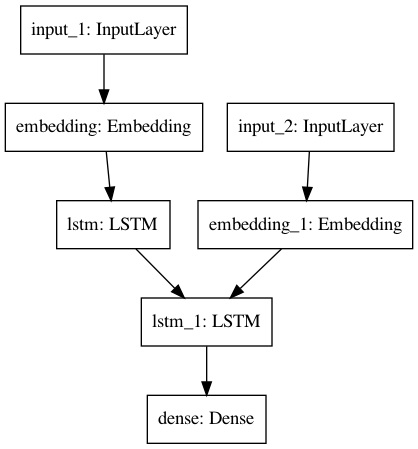

In [47]:
tf.keras.utils.plot_model(model)

In [61]:
training_set_size = len(encoder_input_train)
validation_set_size = len(encoder_input_val)
batch_size = 256
epochs = 2

model.fit_generator(generator=generate_batch(encoder_input_train, decoder_input_train, batch_size=batch_size),
                    steps_per_epoch=training_set_size//batch_size,
                    epochs=epochs,
                    validation_data=generate_batch(encoder_input_val, decoder_input_val, batch_size=batch_size),
                    validation_steps=validation_set_size//batch_size)

Epoch 1/2
10/10 [==============================] - 138s 14s/step - loss: 5.3547 - acc: 0.0790 - val_loss: 5.3125 - val_acc: 0.0830
Epoch 2/2
10/10 [==============================] - 119s 12s/step - loss: 4.9836 - acc: 0.2789 - val_loss: 5.0015 - val_acc: 0.4121
